In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [13]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [14]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        display(df)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

,State,Date,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
0,São Paulo,2003-01,NaN,836.000000,NaN,13.100000,12.000000,93.000000,1.100000,2003
1,São Paulo,2003-02,NaN,836.000000,NaN,13.100000,12.000000,93.000000,1.100000,2003
2,São Paulo,2003-03,NaN,836.034441,NaN,13.126205,11.931653,92.640618,1.226532,2003
3,São Paulo,2003-04,NaN,837.913292,NaN,14.555766,8.946875,73.035211,2.923019,2003
4,São Paulo,2003-05,0.575000,838.471513,1325.367442,13.523726,6.606653,66.100844,2.952266,2003
...,...,...,...,...,...,...,...,...,...,...
235,São Paulo,2022-08,NaN,838.168280,35.810714,11.760887,6.877285,74.848118,1.447177,2022
236,São Paulo,2022-09,NaN,836.747639,22.540741,13.407500,8.960694,77.536111,1.367917,2022
237,São Paulo,2022-10,NaN,835.958199,89.263636,16.209677,12.147715,79.204301,1.416801,2022
238,São Paulo,2022-11,2.657971,834.635000,1021.270370,13.996806,10.997361,83.616667,1.493681,2022


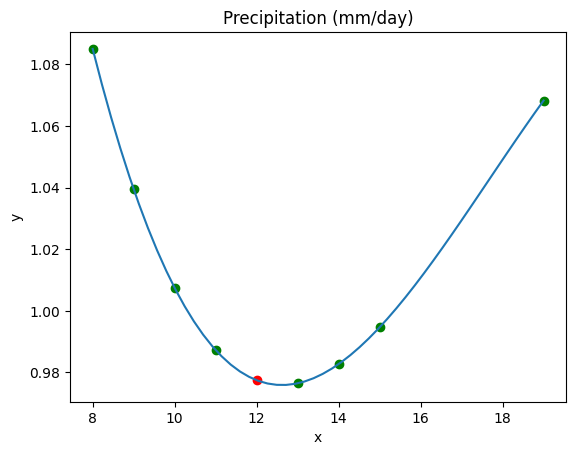

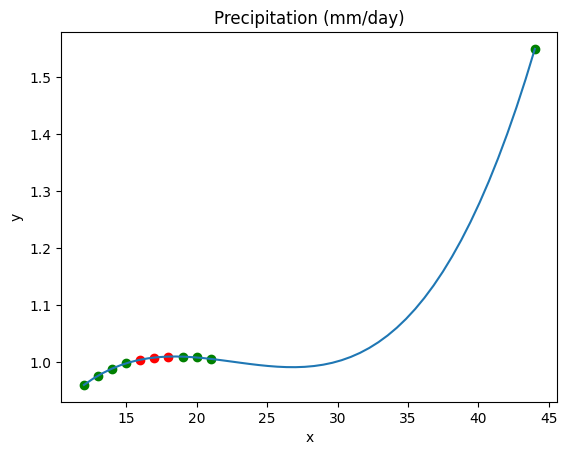

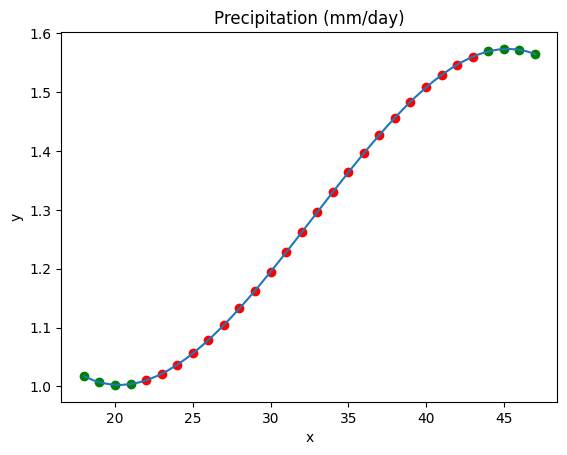

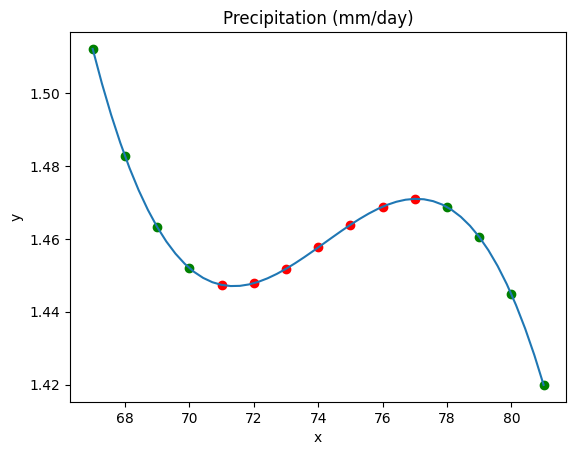

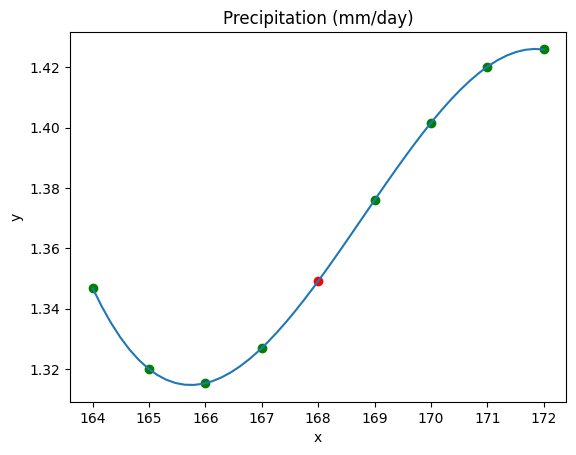

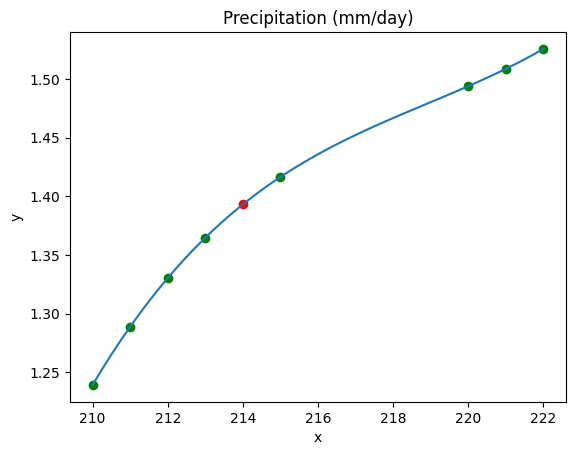

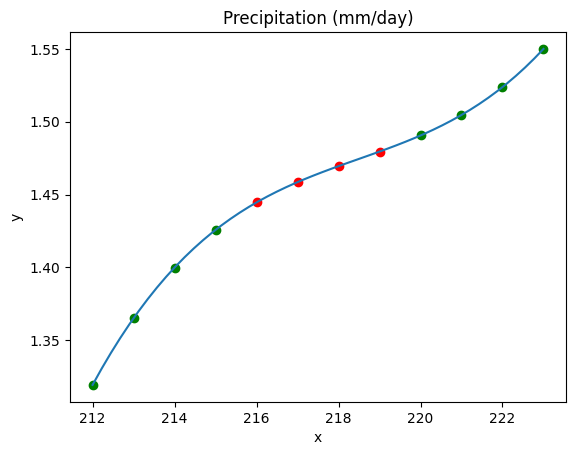

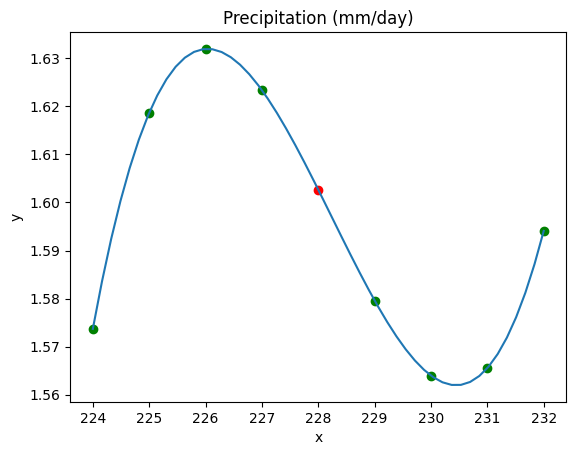

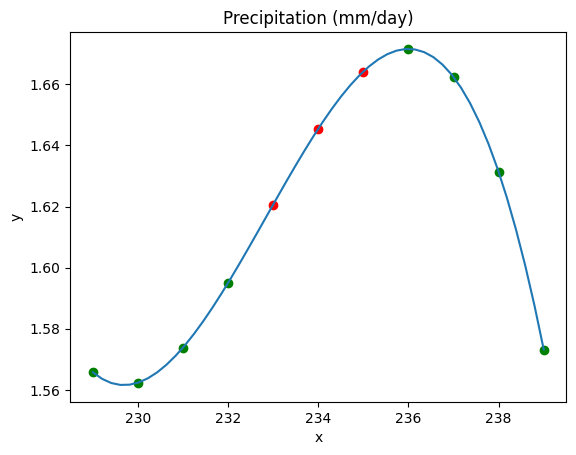

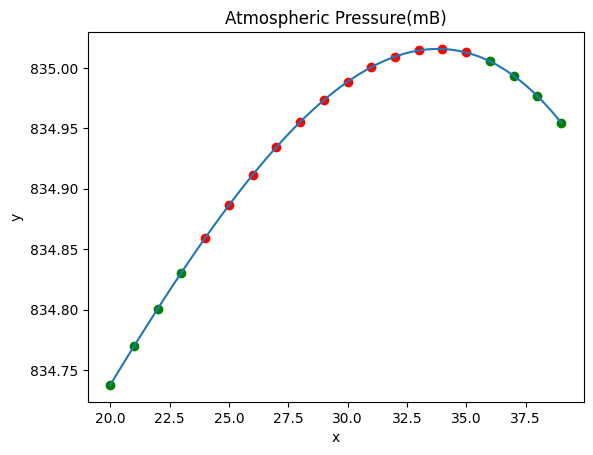

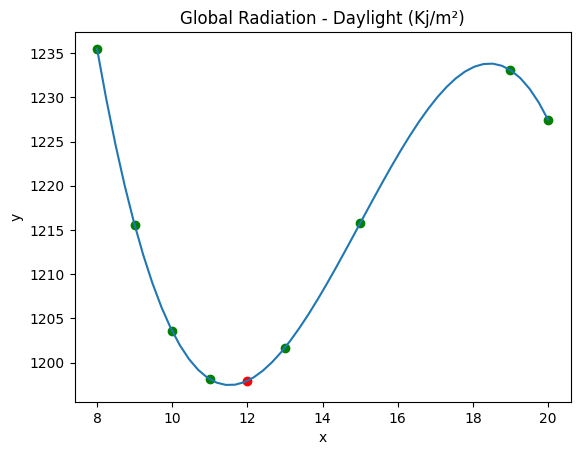

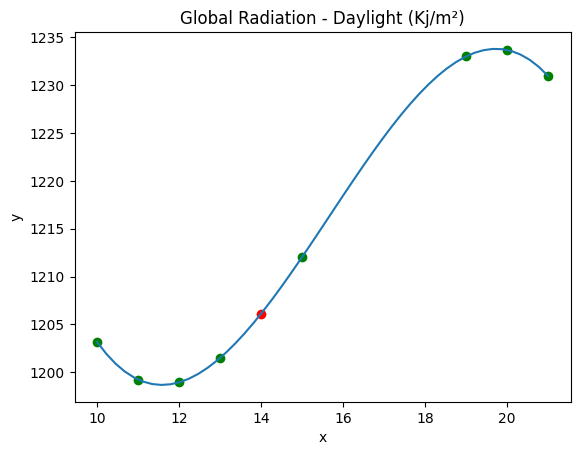

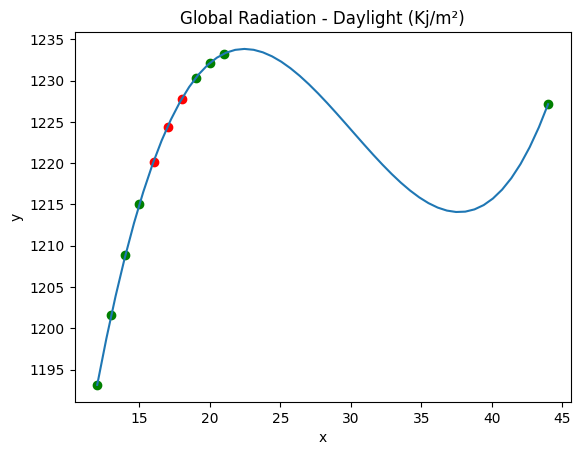

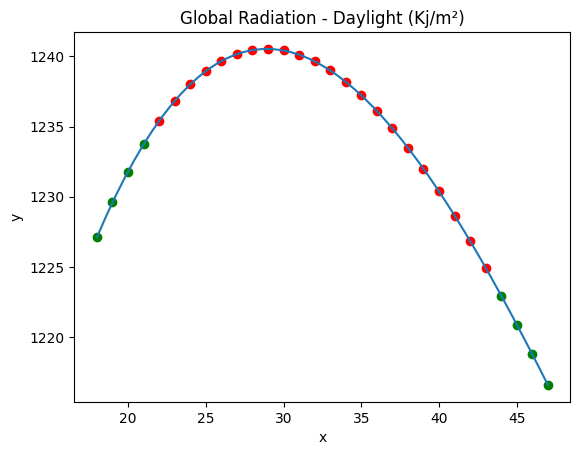

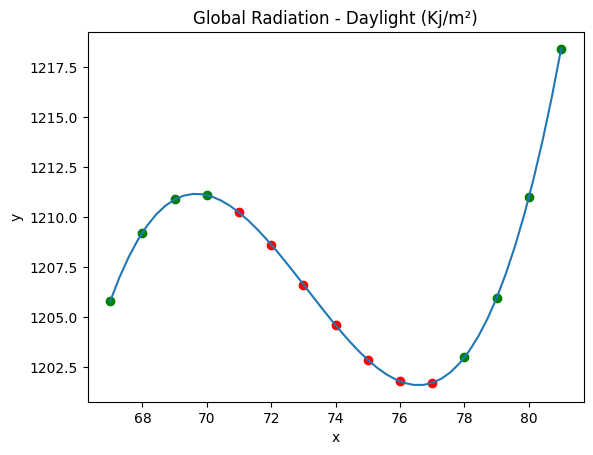

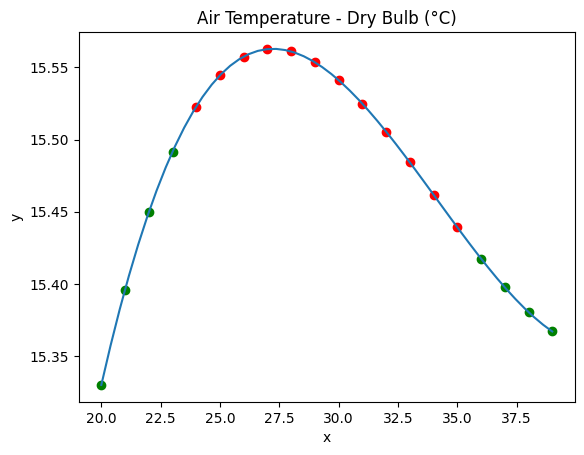

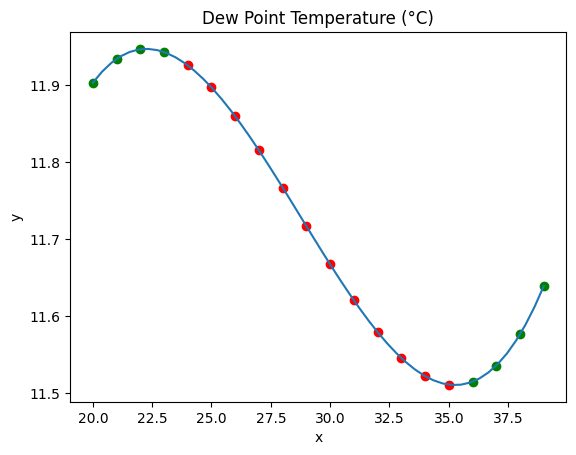

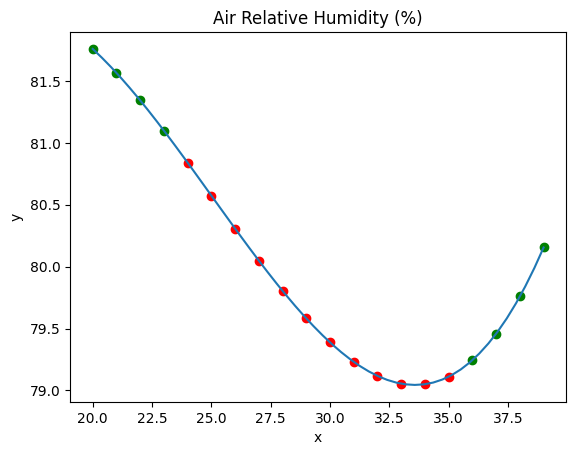

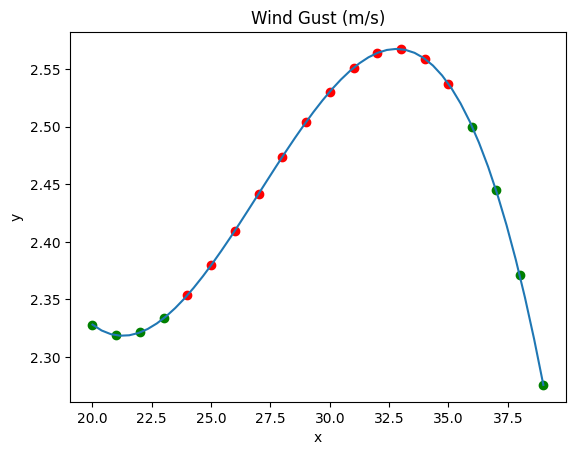

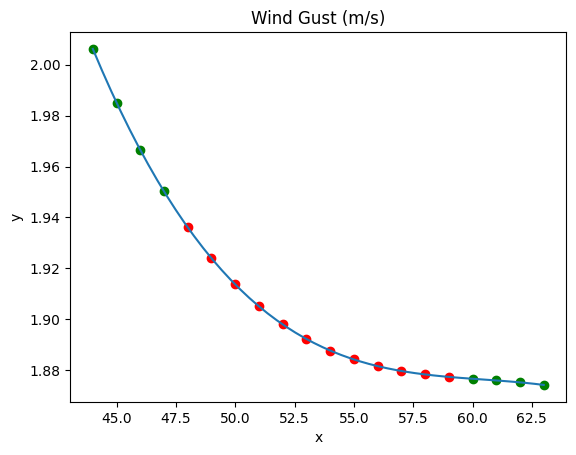

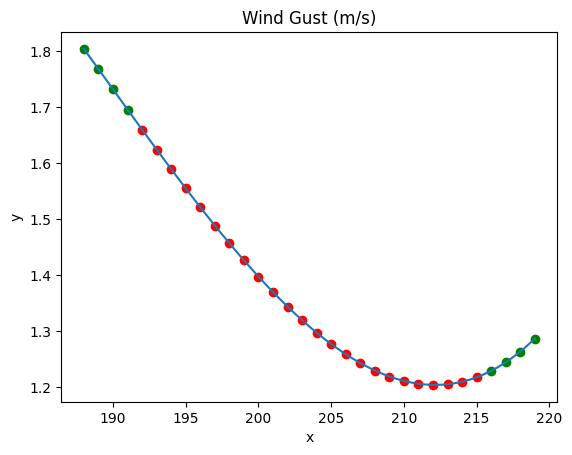

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2003,0.876844,835.549000,1257.300538,14.644477,11.661611,84.390124,1.898762
1,2003,0.893613,835.530208,1253.296602,14.708831,11.647511,84.031379,1.932043
2,2003,0.911314,835.510634,1249.057141,14.775865,11.632824,83.657687,1.966712
3,2003,0.929998,835.488808,1244.568300,14.844601,11.620373,83.283398,1.997553
4,2003,0.949720,835.387788,1239.815409,14.856636,11.731769,83.710406,1.958991
...,...,...,...,...,...,...,...,...
235,2022,1.664181,836.330863,953.787214,14.795837,10.951689,79.563367,1.328487
236,2022,1.673589,836.253973,978.145188,14.895654,11.081555,79.709447,1.323541
237,2022,1.661697,836.223026,1006.720836,14.944740,11.148110,79.773366,1.321692
238,2022,1.632472,836.220989,1037.130043,14.892107,11.098699,79.775850,1.317729


In [15]:
df = read_csv_replace_missing_by_polynomial('sao_paulo_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

In [40]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2003,11.705938,835.133886,1233.536927,15.041641,12.164126,84.902756,1.930011
2004,11.998543,834.672463,1221.573333,15.431817,12.263090,83.152712,2.213838
2005,14.244116,834.963398,1239.361136,15.521599,11.702282,79.675706,2.489308
2006,18.188784,835.110366,1227.217036,15.082585,11.378895,80.384734,2.171811
2007,19.033269,835.834715,1216.383042,14.913017,10.870297,78.901058,1.896576
2008,18.095190,836.334300,1204.525858,15.181901,11.136027,78.961939,1.773094
2009,17.457437,836.629901,1207.913300,15.173450,11.417327,80.559826,1.537503
2010,17.476576,836.656415,1207.430943,14.880006,11.288684,81.499868,1.367891
2011,17.341412,836.557224,1189.112243,14.815765,11.391381,82.321001,1.335640


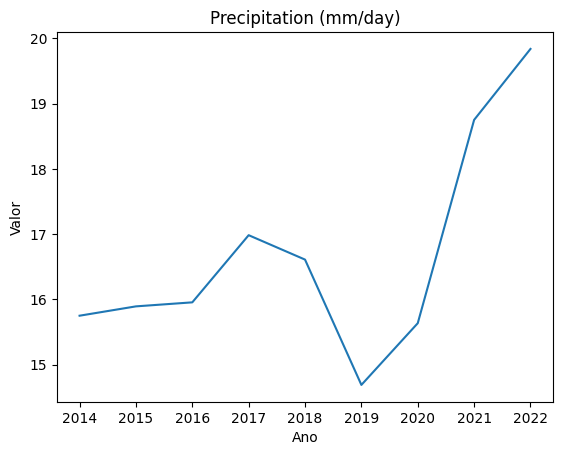

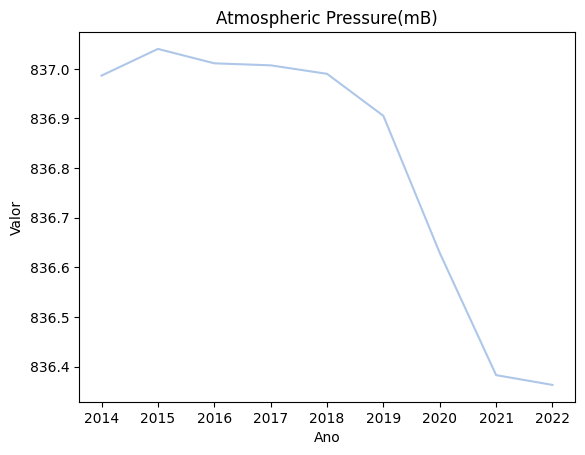

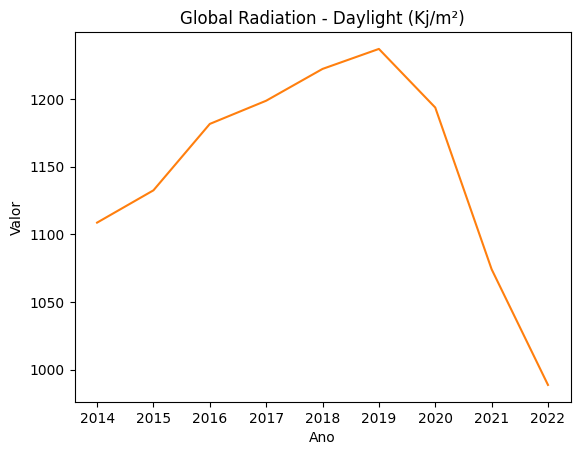

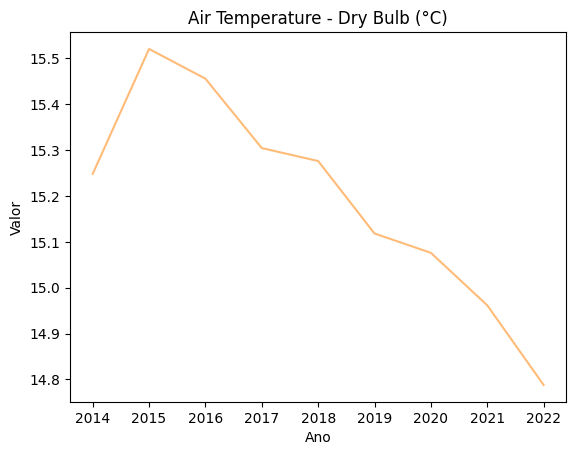

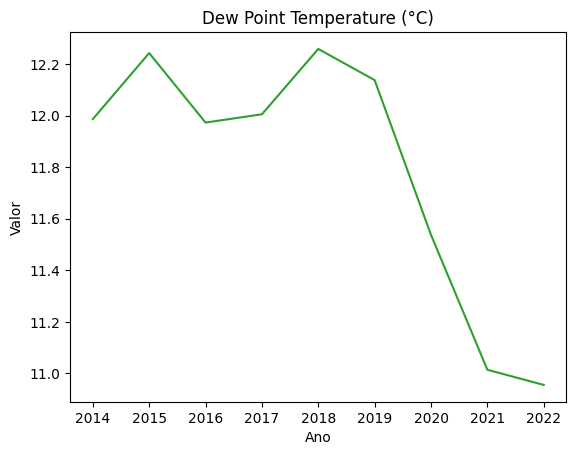

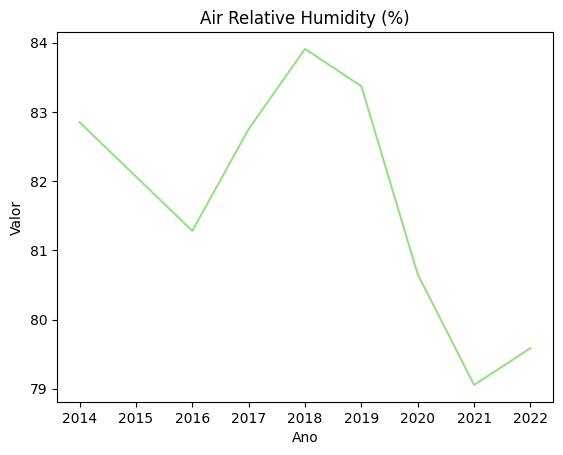

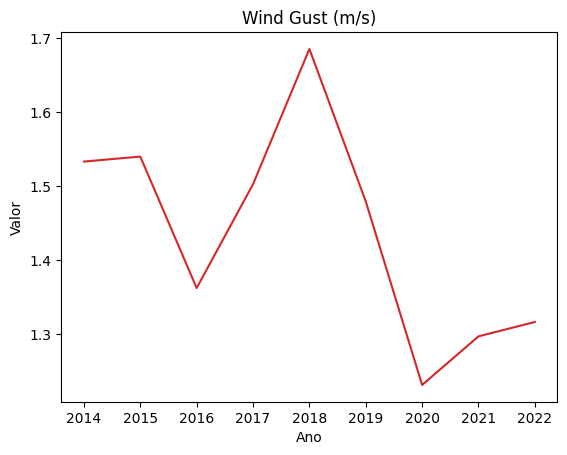

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,15.750987,836.986331,1108.545094,15.247907,11.986366,82.848722,1.532951
2015,15.893940,837.040042,1132.416417,15.520197,12.242333,82.064855,1.539659
2016,15.955560,837.011044,1181.481000,15.455320,11.972800,81.279861,1.362167
2017,16.984321,837.006952,1198.617570,15.304181,12.004953,82.751052,1.502384
2018,16.610359,836.989876,1222.116471,15.275935,12.258430,83.908178,1.685017
2019,14.690772,836.905187,1236.895592,15.118043,12.137404,83.369220,1.479098
2020,15.636063,836.629000,1193.582762,15.075998,11.537222,80.653205,1.231389
2021,18.750427,836.382749,1074.106519,14.961645,11.014166,79.055593,1.296973
2022,19.837339,836.362997,988.639283,14.788160,10.955363,79.586575,1.316356


In [41]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [42]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [44]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,18.095190,836.334300,1204.525858,15.181901,11.136027,78.961939,1.773094
2009,17.457437,836.629901,1207.913300,15.173450,11.417327,80.559826,1.537503
2010,17.476576,836.656415,1207.430943,14.880006,11.288684,81.499868,1.367891
2011,17.341412,836.557224,1189.112243,14.815765,11.391381,82.321001,1.335640
2012,16.745399,836.685833,1175.350304,14.895124,11.497643,82.512436,1.341854
2013,15.620656,836.833718,1154.703253,15.020803,11.542975,82.278650,1.326810
2014,15.750987,836.986331,1108.545094,15.247907,11.986366,82.848722,1.532951
2015,15.893940,837.040042,1132.416417,15.520197,12.242333,82.064855,1.539659
2016,15.955560,837.011044,1181.481000,15.455320,11.972800,81.279861,1.362167


In [45]:
df_2008.to_csv('2008_01_meteo.csv', index=True)